# Port-au-Prince Data Analysis 

### Authors: Carter Murphy, Nick Bourgeois, Mackenzie Kummer, Nolan Penoyer

## Importing Packages

In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from fitter import Fitter, get_common_distributions, get_distributions
from statsmodels.sandbox.stats.runs import runstest_1samp
from datetime import *

## Reading the Data

### Aircraft Capabilities DF: Goes through all aircraft types, then lists the capacity (in tons) of each type of aircraft and the average load of each type of aircraft. 

In [318]:
aircraft_capabilities = pd.read_excel("AircraftCapabilities.xlsx")
aircraft_capabilities.columns = ['Aircraft Type','Capacity (sTon)','Avg Load (sTon)']
aircraft_capabilities.head()

,Aircraft Type,Capacity (sTon),Avg Load (sTon)
0,707,26.0,20.28
1,727,13.0,10.14
2,737,11.0,8.58
3,747,78.0,60.84
4,767,58.0,45.24


### Ground Time DF: Lists an ID for each plane that can also be found in HFOCC data, and pairs the ground time (in hours) for every aircraft. Each ground time observation can be understood as the time from landing at the Port-au-Prince airport to leaving the airport. The ground time is measured in hours. 

In [319]:
ground_time = pd.read_excel("GroundTime.xlsx")
ground_time = ground_time.drop(ground_time.columns[[2,3]], axis=1)
ground_time.columns = ['Ground Time (Hrs)', 'ID']
ground_time.head()

,Ground Time (Hrs),ID
0,1.872,2706
1,0.748,2707
2,1.454,2708
3,1.178,2709
4,1.202,2710


### Daily Demand DF: Lists the average daily demand (in tons) of water, food, medical supplies, and logistics over the specified dates

In [320]:
data = [['13 Jan-28 Jan',390,290,250,700],['29 Jan-28 Feb',195,145,125,200]]
daily_demand = pd.DataFrame(data,columns=['Dates','Water','Food','Medical','Logistics'])
daily_demand

,Dates,Water,Food,Medical,Logistics
0,13 Jan-28 Jan,390,290,250,700
1,29 Jan-28 Feb,195,145,125,200


### HFOCC DF: Has an observation of every aircraft that enters the Port-au-Prince Airport. Lists important items for each of these planes that can be used for the arrival data. 

In [321]:
hfocc = pd.read_excel("HFOCC_Interrarrival_times_hours.xlsx")
hfocc.head()

,Request Status,Arrival Date,Arrival Time,Date/Time,Interarrival Time (hours),Organization,Aircraft Type,Call Sign,Tail #,A/C Size,...,Nationality,Mission purpose,# Pax,CNX DATE,CNX TIME,AF Planner Remarks,AF Manager Remarks,ID,Modified,Created
0,Complete,2010-01-16,0400Z,2010-01-16 04:00:00,0.0,US SENATOR,GULFSTREAM,N450GD,N450GD,N,...,UNITED STATES,PICK UP EVACUEES,14,NaN,NaN,NaN,NaN,2708,2010-02-06 15:01:10,2010-02-03 09:08:54
1,Complete,2010-01-16,1200Z,2010-01-16 12:00:00,8.0,MEXICAN GOVT,C130,MEXICAN AF 3616,3616,N,...,MEXICO,HUMANITARIAN AID,UNK,NaN,NaN,NaN,NaN,2716,2010-02-11 10:48:28,2010-02-03 09:08:54
2,Complete,2010-01-16,1300Z,2010-01-16 13:00:00,1.0,UK GOVT,B727,AJT401,N199AJ,N,...,UK,UNKNOWN,UNK,NaN,NaN,NaN,NaN,2722,2010-02-06 17:17:08,2010-02-03 09:08:55
3,Complete,2010-01-16,1900Z,2010-01-16 19:00:00,6.0,USCG,C130,CG1720,Unknown,N,...,UNITED STATES,SECRETARY OF STATE,UNK,NaN,NaN,NaN,NaN,2748,2010-02-07 03:07:53,2010-02-03 09:08:55
4,Complete,2010-01-16,2000Z,2010-01-16 20:00:00,1.0,USCG,FALCON,C2117,2117,N,...,UNITED STATES,PAX,2,NaN,NaN,NaN,NaN,2755,2010-02-06 15:01:32,2010-02-03 09:08:55


In [322]:
# Total planes that arrive
len(hfocc)

3237

In [323]:
print(hfocc.columns.tolist())

['Request Status', 'Arrival Date', 'Arrival Time', 'Date/Time', 'Interarrival Time (hours)', 'Organization', 'Aircraft Type', 'Call Sign', 'Tail #', 'A/C Size', 'Affiliation', 'Request ID', 'Chg', 'Nationality', 'Mission purpose', '# Pax', 'CNX DATE', 'CNX TIME', 'AF Planner Remarks', 'AF Manager Remarks', 'ID', 'Modified', 'Created']


In [324]:
# Average interarrival time between all aircraft
hfocc['Interarrival Time (hours)'].mean()

2.8535681186283597

## Input Data Analysis of Arrivals

In [325]:
Date_number = hfocc.groupby(['Arrival Date']).count()
Date_number.head()

,Request Status,Arrival Time,Date/Time,Interarrival Time (hours),Organization,Aircraft Type,Call Sign,Tail #,A/C Size,Affiliation,...,Nationality,Mission purpose,# Pax,CNX DATE,CNX TIME,AF Planner Remarks,AF Manager Remarks,ID,Modified,Created
Arrival Date,,,,,,,,,,,,,,,,,,,,,
2010-01-12,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,1,0,1,1,1
2010-01-15,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,0,0,1,1,1
2010-01-16,74,74,74,74,74,74,74,74,74,74,...,74,74,74,0,1,1,0,74,74,74
2010-01-17,132,132,132,132,132,132,132,132,132,132,...,132,132,132,0,0,0,0,132,132,132
2010-01-18,134,134,134,134,134,134,134,134,134,134,...,134,134,134,0,0,0,0,134,134,134


In [326]:
number_plane_date = pd.DataFrame({"Count": list(Date_number["Request Status"])}, index=list(range(1,48)))
number_plane_date.head()

,Count
1,1
2,1
3,74
4,132
5,134


#### Although the amount of planes arriving at the airport can only take on whole numbers, it will still follow a continuous distribution. This is because two planes can't arrive at the Port-au-Prince airport at the same time. Therefore this data is continuous

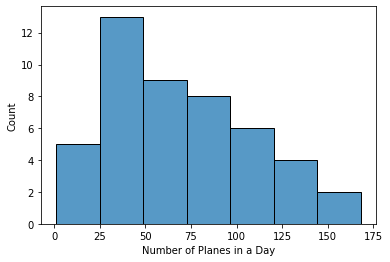

In [327]:
sns.histplot(data=number_plane_date, x="Count").set_xlabel("Number of Planes in a Day")
plt.show()

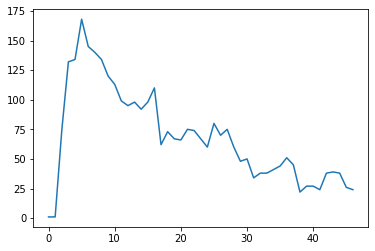

In [501]:
plt.plot(number_plane_date['Count'].values)
plt.show()

### The data is homogenous because it all belongs to one distinct distribution as shown above by the histogram. Also according to the histogram it looks like the data follows an exponential distribution. Meaning that the interarrival time between aircraft follows an exponential distribution.

### The amount of aircraft that arrive per day increases significantly and then decreases until around day 15. This is where the amount of planes per day starts to level off and decrease slighty less. Coincidentally, the 15th day of the simulation is around the same time when the pier re-opened in Haiti. So we will split the data up at the 15th day and see how the data looks. We will also get rid of the first two days because those days only had one plane come in that day. 

In [329]:
first15 = number_plane_date.iloc[2:15,]

In [330]:
remain = number_plane_date.iloc[15:,]

### Now we can recheck for Homogeneity and Stationarity on both DataFrames

#### Before Port Reopened

[]

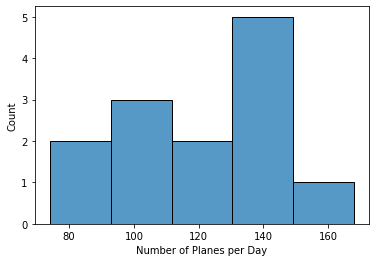

In [331]:
sns.histplot(data=first15, x="Count").set_xlabel("Number of Planes per Day")
plt.plot()

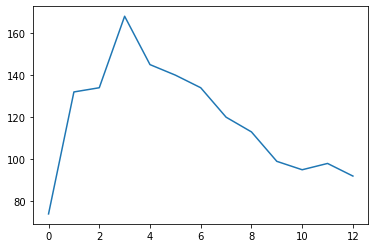

In [332]:
plt.plot(first15["Count"].values)
plt.show()

#### After Port Reopened

[]

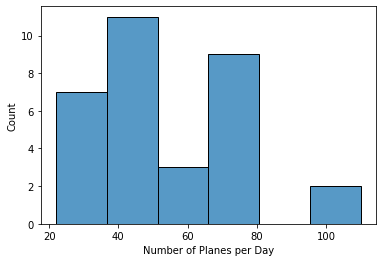

In [333]:
sns.histplot(data=remain, x="Count").set_xlabel("Number of Planes per Day")
plt.plot()

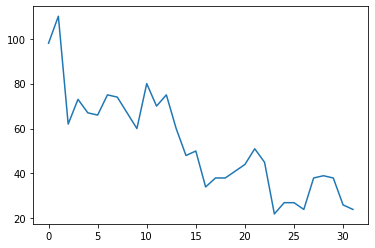

In [334]:
plt.plot(remain["Count"].values)
plt.show()

### The data for before and after the port opened is homogenous, but is still not stationary. This is because the data does not show a constant trend over time

#### Check Independence using a Turning Points Test

#### Before the pier re-opened

In [335]:
def turning_points_test(x):
    dx = np.diff(x)
    return np.sum(dx[1:] * dx[:-1] < 0)

In [336]:
turning_points_test(first15["Count"].values)

3

In [337]:
Mean_R = ((2*len(first15))-4) / 3

In [338]:
Sigma_R2 = ((16*len(first15))-29) / 90

In [339]:
test_stat = (3 - Mean_R) / math.sqrt(Sigma_R2)

In [340]:
stats.norm.ppf(0.025)

-1.9599639845400545

In [341]:
stats.norm.ppf(0.975)

1.959963984540054

In [342]:
if test_stat < stats.norm.ppf(0.025) or test_stat > stats.norm.ppf(0.975):
    print("Reject the null hypothesis that the data is independent")
else:
    print("Fail to reject the null hypothesis that the data is independent")

Reject the null hypothesis that the data is independent


#### After the pier re-opened

In [343]:
turning_points_test(remain["Count"].values)

16

In [344]:
Mean_R = ((2*len(remain))-4) / 3

In [345]:
Sigma_R2 = ((16*len(remain))-29) / 90

In [346]:
test_stat = (16 - Mean_R) / math.sqrt(Sigma_R2)

In [347]:
if test_stat < stats.norm.ppf(0.025) or test_stat > stats.norm.ppf(0.975):
    print("Reject the null hypothesis that the data is independent")
else:
    print("Fail to reject the null hypothesis that the data is independent")

Fail to reject the null hypothesis that the data is independent


### The turning points test indicated that the data before the pier opened is not independent, but that the data after the pier opened is independent. This could be explained by the sudden increase in planes at the start of the crisis and then the slight decrease as less supplies were needed by the Haitian people. 

## Manipulation of the HFOCC DF

### HFOCC1 DF: Merging the original HFOCC DF with the Aircraft Capabilities DF on the Aircraft Type column that they share. This adds the average load and capacity for every aircraft that enters the Port-au-Prince airport. 

In [348]:
hfocc1 = pd.merge(hfocc, aircraft_capabilities, on="Aircraft Type")
hfocc1

,Request Status,Arrival Date,Arrival Time,Date/Time,Interarrival Time (hours),Organization,Aircraft Type,Call Sign,Tail #,A/C Size,...,# Pax,CNX DATE,CNX TIME,AF Planner Remarks,AF Manager Remarks,ID,Modified,Created,Capacity (sTon),Avg Load (sTon)
0,Complete,2010-01-16,0400Z,2010-01-16 04:00:00,0.000000,US SENATOR,GULFSTREAM,N450GD,N450GD,N,...,14,NaN,NaN,NaN,NaN,2708,2010-02-06 15:01:10,2010-02-03 09:08:54,0.5,0.39
1,Complete,2010-01-16,0400Z,2010-01-16 04:00:00,0.000000,US SENATOR,GULFSTREAM,N450GD,N450GD,N,...,14,NaN,NaN,NaN,NaN,2708,2010-02-06 15:01:10,2010-02-03 09:08:54,0.5,0.39
2,Complete,2010-01-18,0840Z,2010-01-18 08:40:00,2.666667,FAA,GULFSTREAM,N922H,N922H,N,...,UNK,NaN,NaN,NaN,NaN,2957,2010-02-06 15:02:01,2010-02-03 09:08:59,0.5,0.39
3,Complete,2010-01-18,0840Z,2010-01-18 08:40:00,2.666667,FAA,GULFSTREAM,N922H,N922H,N,...,UNK,NaN,NaN,NaN,NaN,2957,2010-02-06 15:02:01,2010-02-03 09:08:59,0.5,0.39
4,Complete,2010-01-23,2000Z,2010-01-23 20:00:00,3.000000,PHOENIX AIR GROUP,GULFSTREAM,PHOENIX 173,N173PA,N,...,UNK,NaN,NaN,NaN,NaN,3699,2010-02-06 15:01:15,2010-02-03 09:09:14,0.5,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,Complete,2010-03-01,1430Z,2010-03-01 14:30:00,16.250000,USVI HAITIAN RELIEF,BEECH55G,N621G,N621G,S,...,NaN,NaN,NaN,NaN,NaN,8385,2010-03-01 10:52:14,2010-02-27 15:29:33,0.5,0.39
4267,Complete,2010-01-21,2140Z,2010-01-21 21:40:00,4.666667,EMSI,DC12,N654JC,N654JC,W,...,UNK,NaN,NaN,NaN,NaN,3457,2010-02-06 15:14:30,2010-02-03 09:09:09,52.0,40.56
4268,Complete,2010-01-27,1400Z,2010-01-27 14:00:00,26.000000,ELAL,B777,ELY2601,4XECD,W,...,20,NaN,NaN,NaN,NaN,4068,2010-02-06 16:51:24,2010-02-03 09:09:21,119.0,92.82
4269,Complete,2010-02-27,1600Z,2010-02-27 16:00:00,4.000000,MINUSTAH (UN),B777,KE9073,UNKNOWN,W,...,310,NaN,NaN,NaN,NaN,7302,2010-02-27 14:38:15,2010-02-09 17:24:18,119.0,92.82


In [349]:
# Dropping duplicate observations that show up due to merging the dataframe
hfocc2 = hfocc1.drop_duplicates()
len(hfocc2)

3187

## Splitting HFOCC DF Into Pre & Post Pier Opening

In [350]:
Before_Pier = hfocc2[hfocc2["Arrival Date"] < "2010-01-28"]
Before_Pier.head()

,Request Status,Arrival Date,Arrival Time,Date/Time,Interarrival Time (hours),Organization,Aircraft Type,Call Sign,Tail #,A/C Size,...,# Pax,CNX DATE,CNX TIME,AF Planner Remarks,AF Manager Remarks,ID,Modified,Created,Capacity (sTon),Avg Load (sTon)
0,Complete,2010-01-16,0400Z,2010-01-16 04:00:00,0.000000,US SENATOR,GULFSTREAM,N450GD,N450GD,N,...,14,NaN,NaN,NaN,NaN,2708,2010-02-06 15:01:10,2010-02-03 09:08:54,0.5,0.39
2,Complete,2010-01-18,0840Z,2010-01-18 08:40:00,2.666667,FAA,GULFSTREAM,N922H,N922H,N,...,UNK,NaN,NaN,NaN,NaN,2957,2010-02-06 15:02:01,2010-02-03 09:08:59,0.5,0.39
4,Complete,2010-01-23,2000Z,2010-01-23 20:00:00,3.000000,PHOENIX AIR GROUP,GULFSTREAM,PHOENIX 173,N173PA,N,...,UNK,NaN,NaN,NaN,NaN,3699,2010-02-06 15:01:15,2010-02-03 09:09:14,0.5,0.39
6,Complete,2010-01-24,2000Z,2010-01-24 20:00:00,5.666667,PHOENIX AIR GROUP,GULFSTREAM,PHOENIX 173,N173PA,N,...,UNK,NaN,NaN,NaN,NaN,3811,2010-02-06 15:01:15,2010-02-03 09:09:16,0.5,0.39
24,Complete,2010-01-16,1700Z,2010-01-16 17:00:00,0.000000,MEDSHARE,GULFSTREAM,N954L,Unknown,N,...,UNK,NaN,NaN,NaN,NaN,2736,2010-02-07 02:35:01,2010-02-03 09:08:55,0.5,0.39


In [351]:
After_Pier = hfocc2[hfocc2["Arrival Date"] >= "2010-01-28"]
After_Pier.head()

,Request Status,Arrival Date,Arrival Time,Date/Time,Interarrival Time (hours),Organization,Aircraft Type,Call Sign,Tail #,A/C Size,...,# Pax,CNX DATE,CNX TIME,AF Planner Remarks,AF Manager Remarks,ID,Modified,Created,Capacity (sTon),Avg Load (sTon)
8,Complete,2010-01-30,0215Z,2010-01-30 02:15:00,1.50,CDC,GULFSTREAM,PHOENIX 173,N173PA,N,...,UNK,NaN,NaN,NaN,NaN,4325,2010-02-06 15:01:29,2010-02-03 09:09:26,0.5,0.39
10,Complete,2010-01-31,2015Z,2010-01-31 20:15:00,7.50,PHOENIX AIR GROUP,GULFSTREAM,PHOENIX 173,N173PA,N,...,UNK,NaN,NaN,NaN,NaN,4477,2010-02-06 15:01:15,2010-02-03 09:09:30,0.5,0.39
12,Complete,2010-02-04,2230Z,2010-02-04 22:30:00,2.25,SKY LIMO AIR CHARTER,GULFSTREAM,212BA,212BA,N,...,10,NaN,NaN,Duplicate of 3818,NaN,4810,2010-02-12 08:28:24,2010-02-03 09:09:36,0.5,0.39
14,Complete,2010-02-07,1600Z,2010-02-07 16:00:00,5.25,PHOENIX AIR GROUP,GULFSTREAM,PHA173,N173PA,N,...,UNK,NaN,NaN,NaN,NaN,4993,2010-02-11 13:24:53,2010-02-03 09:09:40,0.5,0.39
16,Complete,2010-02-11,2045Z,2010-02-11 20:45:00,29.50,CDC,GULFSTREAM,PHA173,N173PA,N,...,12,NaN,NaN,NaN,NaN,5153,2010-02-11 15:47:15,2010-02-03 09:09:43,0.5,0.39


### HFOCC3 DF: Gets rid of all of the small planes from the HFOCC2 DF. This will help when calculating the distributions for the primary offloading ramps

In [352]:
hfocc3_before = Before_Pier[Before_Pier['A/C Size'] != "S"]

In [353]:
hfocc3_after = After_Pier[After_Pier['A/C Size'] != "S"]

### HFOCC TIDY DF: Grabs important variables from HFOCC Dataframes for the whole simulation, and then before and after the pier opened

In [354]:
hfocc_tidy = hfocc2[['Request Status','Arrival Date','Interarrival Time (hours)','Aircraft Type','A/C Size','Affiliation','Avg Load (sTon)']]
hfocc_tidy.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
0,Complete,2010-01-16,0.000000,GULFSTREAM,N,GOV,0.39
2,Complete,2010-01-18,2.666667,GULFSTREAM,N,GOV,0.39
4,Complete,2010-01-23,3.000000,GULFSTREAM,N,GOV,0.39
6,Complete,2010-01-24,5.666667,GULFSTREAM,N,GOV,0.39
8,Complete,2010-01-30,1.500000,GULFSTREAM,N,GOV,0.39


In [355]:
hfocc_tidy_before = Before_Pier[['Request Status','Arrival Date','Interarrival Time (hours)','Aircraft Type','A/C Size','Affiliation','Avg Load (sTon)']]
hfocc_tidy_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
0,Complete,2010-01-16,0.000000,GULFSTREAM,N,GOV,0.39
2,Complete,2010-01-18,2.666667,GULFSTREAM,N,GOV,0.39
4,Complete,2010-01-23,3.000000,GULFSTREAM,N,GOV,0.39
6,Complete,2010-01-24,5.666667,GULFSTREAM,N,GOV,0.39
24,Complete,2010-01-16,0.000000,GULFSTREAM,N,NGO,0.39


In [356]:
hfocc_tidy_after = After_Pier[['Request Status','Arrival Date','Interarrival Time (hours)','Aircraft Type','A/C Size','Affiliation','Avg Load (sTon)']]
hfocc_tidy_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
8,Complete,2010-01-30,1.50,GULFSTREAM,N,GOV,0.39
10,Complete,2010-01-31,7.50,GULFSTREAM,N,GOV,0.39
12,Complete,2010-02-04,2.25,GULFSTREAM,N,GOV,0.39
14,Complete,2010-02-07,5.25,GULFSTREAM,N,GOV,0.39
16,Complete,2010-02-11,29.50,GULFSTREAM,N,GOV,0.39


## Splitting HFOCC Tidy DF into 3 Seperate Dataframes Based on A/C Size for the whole simulation, and then before and after the pier opened

In [357]:
plane_narrow = hfocc_tidy[hfocc_tidy['A/C Size'] == 'N']
plane_narrow.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
0,Complete,2010-01-16,0.000000,GULFSTREAM,N,GOV,0.39
2,Complete,2010-01-18,2.666667,GULFSTREAM,N,GOV,0.39
4,Complete,2010-01-23,3.000000,GULFSTREAM,N,GOV,0.39
6,Complete,2010-01-24,5.666667,GULFSTREAM,N,GOV,0.39
8,Complete,2010-01-30,1.500000,GULFSTREAM,N,GOV,0.39


In [358]:
plane_wide = hfocc_tidy[hfocc_tidy['A/C Size'] == 'W']
plane_wide.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1496,Complete,2010-02-22,8.000000,IL76,W,GOV,14.820
1508,Complete,2010-01-29,51.250000,IL76,W,MIL,14.820
1820,Complete,2010-01-29,19.000000,CHALLENGER,W,NGO,0.156
1874,Complete,2010-01-19,13.000000,B747,W,GOV,60.840
1875,Complete,2010-01-21,6.016667,B747,W,GOV,60.840


In [359]:
plane_small = hfocc_tidy[hfocc_tidy['A/C Size'] == 'S']
plane_small.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
166,Complete,2010-01-30,0.250000,GULFSTREAM,S,NGO,0.39
168,Complete,2010-01-31,1.266667,GULFSTREAM,S,NGO,0.39
170,Complete,2010-01-31,1.250000,GULFSTREAM,S,NGO,0.39
1258,Complete,2010-02-05,34.666667,C130,S,MIL,7.00
1427,Complete,2010-01-16,0.000000,FALCON,S,NGO,2.34


In [360]:
plane_narrow_before = hfocc_tidy_before[hfocc_tidy_before['A/C Size'] == 'N']
plane_narrow_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
0,Complete,2010-01-16,0.000000,GULFSTREAM,N,GOV,0.39
2,Complete,2010-01-18,2.666667,GULFSTREAM,N,GOV,0.39
4,Complete,2010-01-23,3.000000,GULFSTREAM,N,GOV,0.39
6,Complete,2010-01-24,5.666667,GULFSTREAM,N,GOV,0.39
24,Complete,2010-01-16,0.000000,GULFSTREAM,N,NGO,0.39


In [361]:
plane_wide_before = hfocc_tidy_before[hfocc_tidy_before['A/C Size'] == 'W']
plane_wide_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1874,Complete,2010-01-19,13.000000,B747,W,GOV,60.84
1875,Complete,2010-01-21,6.016667,B747,W,GOV,60.84
1876,Complete,2010-01-23,30.333333,B747,W,GOV,60.84
1881,Complete,2010-01-20,3.000000,B747,W,NGO,60.84
1882,Complete,2010-01-22,4.000000,B747,W,NGO,60.84


In [362]:
plane_small_before = hfocc_tidy_before[hfocc_tidy_before['A/C Size'] == 'S']
plane_small_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1427,Complete,2010-01-16,0.0,FALCON,S,NGO,2.34
1428,Complete,2010-01-16,0.0,FALCON,S,NGO,2.34
1464,Complete,2010-01-15,0.0,UNKNOWN,S,MIL,0.78
1466,Complete,2010-01-16,0.0,UNKNOWN,S,NGO,0.78
1467,Complete,2010-01-16,0.5,UNKNOWN,S,NGO,0.78


In [363]:
plane_narrow_after = hfocc_tidy_after[hfocc_tidy_after['A/C Size'] == 'N']
plane_narrow_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
8,Complete,2010-01-30,1.50,GULFSTREAM,N,GOV,0.39
10,Complete,2010-01-31,7.50,GULFSTREAM,N,GOV,0.39
12,Complete,2010-02-04,2.25,GULFSTREAM,N,GOV,0.39
14,Complete,2010-02-07,5.25,GULFSTREAM,N,GOV,0.39
16,Complete,2010-02-11,29.50,GULFSTREAM,N,GOV,0.39


In [364]:
plane_wide_after = hfocc_tidy_after[hfocc_tidy_after['A/C Size'] == 'W']
plane_wide_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1496,Complete,2010-02-22,8.00,IL76,W,GOV,14.820
1508,Complete,2010-01-29,51.25,IL76,W,MIL,14.820
1820,Complete,2010-01-29,19.00,CHALLENGER,W,NGO,0.156
1877,Complete,2010-02-02,72.00,B747,W,GOV,60.840
1878,Complete,2010-02-08,16.00,B747,W,GOV,60.840


In [365]:
plane_small_after = hfocc_tidy_after[hfocc_tidy_after['A/C Size'] == 'S']
plane_small_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
166,Complete,2010-01-30,0.250000,GULFSTREAM,S,NGO,0.39
168,Complete,2010-01-31,1.266667,GULFSTREAM,S,NGO,0.39
170,Complete,2010-01-31,1.250000,GULFSTREAM,S,NGO,0.39
1258,Complete,2010-02-05,34.666667,C130,S,MIL,7.00
1429,Complete,2010-02-08,0.500000,FALCON,S,NGO,2.34


### The new data set containing important arrival and ground time data has been split into six different dataframes, 3 before the pier opened, and 3 after the pier opened. Each dataframe corresponds to the three different sizes of planes arriving into Port-au-Prince airport.

## Splitting the data into 9 dataframes based on A/C Size and Affiliation for before and after the pier opened

### Each plane has three dataframes. The first dataframe contains all of the planes over the whole simulation. The second dataframe contains all of the planes that arrived before the port re-opened in Haiti. The third and final dataframe contains all of the planes that arrived after the port re-opened in Haiti 

### Wide military planes 

In [366]:
plane_wide_mil = plane_wide[plane_wide['Affiliation'] == 'MIL']
plane_wide_mil.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1508,Complete,2010-01-29,51.25,IL76,W,MIL,14.82
2829,Complete,2010-01-17,7.00,A310,W,MIL,25.74
2830,Complete,2010-01-17,3.00,A310,W,MIL,25.74
2831,Complete,2010-01-17,2.00,A310,W,MIL,25.74
2832,Complete,2010-01-17,2.00,A310,W,MIL,25.74


In [367]:
plane_wide_mil_before = plane_wide_before[plane_wide_before['Affiliation'] == 'MIL']
plane_wide_mil_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
2829,Complete,2010-01-17,7.0,A310,W,MIL,25.74
2830,Complete,2010-01-17,3.0,A310,W,MIL,25.74
2831,Complete,2010-01-17,2.0,A310,W,MIL,25.74
2832,Complete,2010-01-17,2.0,A310,W,MIL,25.74
2833,Complete,2010-01-18,4.0,A310,W,MIL,25.74


In [368]:
plane_wide_mil_after = plane_wide_after[plane_wide_after['Affiliation'] == 'MIL']
plane_wide_mil_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1508,Complete,2010-01-29,51.25,IL76,W,MIL,14.82
3010,Complete,2010-01-30,14.75,B767,W,MIL,45.24
3011,Complete,2010-02-06,169.00,B767,W,MIL,45.24
3012,Complete,2010-02-09,82.00,B767,W,MIL,45.24
3013,Complete,2010-02-11,52.00,B767,W,MIL,45.24


### Wide government planes

In [369]:
plane_wide_gov = plane_wide[plane_wide['Affiliation'] == 'GOV']
plane_wide_gov.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1496,Complete,2010-02-22,8.000000,IL76,W,GOV,14.82
1874,Complete,2010-01-19,13.000000,B747,W,GOV,60.84
1875,Complete,2010-01-21,6.016667,B747,W,GOV,60.84
1876,Complete,2010-01-23,30.333333,B747,W,GOV,60.84
1877,Complete,2010-02-02,72.000000,B747,W,GOV,60.84


In [370]:
plane_wide_gov_before = plane_wide_before[plane_wide_before['Affiliation'] == 'GOV']
plane_wide_gov_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1874,Complete,2010-01-19,13.000000,B747,W,GOV,60.84
1875,Complete,2010-01-21,6.016667,B747,W,GOV,60.84
1876,Complete,2010-01-23,30.333333,B747,W,GOV,60.84
2825,Complete,2010-01-18,23.000000,A310,W,GOV,25.74
2826,Complete,2010-01-22,24.000000,A310,W,GOV,25.74


In [371]:
plane_wide_gov_after = plane_wide_after[plane_wide_after['Affiliation'] == 'GOV']
plane_wide_gov_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1496,Complete,2010-02-22,8.0,IL76,W,GOV,14.82
1877,Complete,2010-02-02,72.0,B747,W,GOV,60.84
1878,Complete,2010-02-08,16.0,B747,W,GOV,60.84
1879,Complete,2010-02-19,15.5,B747,W,GOV,60.84
1917,Complete,2010-02-22,20.0,DC8,W,GOV,68.64


### Wide non-governmental planes 

In [372]:
plane_wide_ngo = plane_wide[plane_wide['Affiliation'] == 'NGO']
plane_wide_ngo.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1820,Complete,2010-01-29,19.000000,CHALLENGER,W,NGO,0.156
1881,Complete,2010-01-20,3.000000,B747,W,NGO,60.840
1882,Complete,2010-01-22,4.000000,B747,W,NGO,60.840
1883,Complete,2010-01-26,11.983333,B747,W,NGO,60.840
1884,Complete,2010-01-30,4.016667,B747,W,NGO,60.840


In [373]:
plane_wide_ngo_before = plane_wide_before[plane_wide_before['Affiliation'] == 'NGO']
plane_wide_ngo_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1881,Complete,2010-01-20,3.000000,B747,W,NGO,60.84
1882,Complete,2010-01-22,4.000000,B747,W,NGO,60.84
1883,Complete,2010-01-26,11.983333,B747,W,NGO,60.84
2944,Complete,2010-01-17,2.000000,B757,W,NGO,20.07
2945,Complete,2010-01-20,4.000000,B757,W,NGO,20.07


In [374]:
plane_wide_ngo_after = plane_wide_after[plane_wide_after['Affiliation'] == 'NGO']
plane_wide_ngo_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1820,Complete,2010-01-29,19.000000,CHALLENGER,W,NGO,0.156
1884,Complete,2010-01-30,4.016667,B747,W,NGO,60.840
1885,Complete,2010-01-30,4.000000,B747,W,NGO,60.840
1886,Complete,2010-01-31,4.016667,B747,W,NGO,60.840
1887,Complete,2010-02-01,8.016667,B747,W,NGO,60.840


### Narrow military planes

In [375]:
plane_narrow_mil = plane_narrow[plane_narrow['Affiliation'] == 'MIL']
plane_narrow_mil.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
308,Complete,2010-01-16,1.0,C130,N,MIL,7.0
310,Complete,2010-01-16,1.0,C130,N,MIL,7.0
312,Complete,2010-01-16,1.0,C130,N,MIL,7.0
314,Complete,2010-01-16,0.0,C130,N,MIL,7.0
316,Complete,2010-01-16,1.0,C130,N,MIL,7.0


In [376]:
plane_narrow_mil_before = plane_narrow_before[plane_narrow_before['Affiliation'] == 'MIL']
plane_narrow_mil_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
308,Complete,2010-01-16,1.0,C130,N,MIL,7.0
310,Complete,2010-01-16,1.0,C130,N,MIL,7.0
312,Complete,2010-01-16,1.0,C130,N,MIL,7.0
314,Complete,2010-01-16,0.0,C130,N,MIL,7.0
316,Complete,2010-01-16,1.0,C130,N,MIL,7.0


In [377]:
plane_narrow_mil_after = plane_narrow_after[plane_narrow_after['Affiliation'] == 'MIL']
plane_narrow_mil_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
742,Complete,2010-01-28,2.50,C130,N,MIL,7.0
744,Complete,2010-01-28,0.00,C130,N,MIL,7.0
746,Complete,2010-01-28,0.25,C130,N,MIL,7.0
748,Complete,2010-01-28,0.75,C130,N,MIL,7.0
750,Complete,2010-01-29,2.00,C130,N,MIL,7.0


### Narrow government planes

In [378]:
plane_narrow_gov = plane_narrow[plane_narrow['Affiliation'] == 'GOV']
plane_narrow_gov.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
0,Complete,2010-01-16,0.000000,GULFSTREAM,N,GOV,0.39
2,Complete,2010-01-18,2.666667,GULFSTREAM,N,GOV,0.39
4,Complete,2010-01-23,3.000000,GULFSTREAM,N,GOV,0.39
6,Complete,2010-01-24,5.666667,GULFSTREAM,N,GOV,0.39
8,Complete,2010-01-30,1.500000,GULFSTREAM,N,GOV,0.39


In [379]:
plane_narrow_gov_before = plane_narrow_before[plane_narrow_before['Affiliation'] == 'GOV']
plane_narrow_gov_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
0,Complete,2010-01-16,0.000000,GULFSTREAM,N,GOV,0.39
2,Complete,2010-01-18,2.666667,GULFSTREAM,N,GOV,0.39
4,Complete,2010-01-23,3.000000,GULFSTREAM,N,GOV,0.39
6,Complete,2010-01-24,5.666667,GULFSTREAM,N,GOV,0.39
172,Complete,2010-01-16,8.000000,C130,N,GOV,7.00


In [380]:
plane_narrow_gov_after = plane_narrow_after[plane_narrow_after['Affiliation'] == 'GOV']
plane_narrow_gov_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
8,Complete,2010-01-30,1.50,GULFSTREAM,N,GOV,0.39
10,Complete,2010-01-31,7.50,GULFSTREAM,N,GOV,0.39
12,Complete,2010-02-04,2.25,GULFSTREAM,N,GOV,0.39
14,Complete,2010-02-07,5.25,GULFSTREAM,N,GOV,0.39
16,Complete,2010-02-11,29.50,GULFSTREAM,N,GOV,0.39


### Narrow non-governmental planes

In [381]:
plane_narrow_ngo = plane_narrow[plane_narrow['Affiliation'] == 'NGO']
plane_narrow_ngo.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
24,Complete,2010-01-16,0.0,GULFSTREAM,N,NGO,0.39
26,Complete,2010-01-16,0.0,GULFSTREAM,N,NGO,0.39
28,Complete,2010-01-16,0.0,GULFSTREAM,N,NGO,0.39
30,Complete,2010-01-16,0.0,GULFSTREAM,N,NGO,0.39
32,Complete,2010-01-17,0.0,GULFSTREAM,N,NGO,0.39


In [382]:
plane_narrow_ngo_before = plane_narrow_before[plane_narrow_before['Affiliation'] == 'NGO']
plane_narrow_ngo_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
24,Complete,2010-01-16,0.0,GULFSTREAM,N,NGO,0.39
26,Complete,2010-01-16,0.0,GULFSTREAM,N,NGO,0.39
28,Complete,2010-01-16,0.0,GULFSTREAM,N,NGO,0.39
30,Complete,2010-01-16,0.0,GULFSTREAM,N,NGO,0.39
32,Complete,2010-01-17,0.0,GULFSTREAM,N,NGO,0.39


In [383]:
plane_narrow_ngo_after = plane_narrow_after[plane_narrow_after['Affiliation'] == 'NGO']
plane_narrow_ngo_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
122,Complete,2010-01-28,0.500000,GULFSTREAM,N,NGO,0.39
124,Complete,2010-01-29,0.500000,GULFSTREAM,N,NGO,0.39
126,Complete,2010-01-29,1.000000,GULFSTREAM,N,NGO,0.39
128,Complete,2010-01-30,1.266667,GULFSTREAM,N,NGO,0.39
130,Complete,2010-01-30,2.250000,GULFSTREAM,N,NGO,0.39


### Small military planes

In [384]:
plane_small_mil = plane_small[plane_small['Affiliation'] == 'MIL']
plane_small_mil.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1258,Complete,2010-02-05,34.666667,C130,S,MIL,7.00
1457,Complete,2010-02-10,2.500000,SF34,S,MIL,0.19
1464,Complete,2010-01-15,0.000000,UNKNOWN,S,MIL,0.78
1866,Complete,2010-02-09,2.500000,C26,S,MIL,0.78
1867,Complete,2010-03-01,1.750000,C26,S,MIL,0.78


In [385]:
plane_small_mil_before = plane_small_before[plane_small_before['Affiliation'] == 'MIL']
plane_small_mil_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1464,Complete,2010-01-15,0.000000,UNKNOWN,S,MIL,0.78
2616,Complete,2010-01-20,29.000000,C12,S,MIL,0.78
2618,Complete,2010-01-20,5.333333,C12,S,MIL,0.78
2620,Complete,2010-01-21,15.333333,C12,S,MIL,0.78
2622,Complete,2010-01-21,1.000000,C12,S,MIL,0.78


In [386]:
plane_small_mil_after = plane_small_after[plane_small_after['Affiliation'] == 'MIL']
plane_small_mil_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1258,Complete,2010-02-05,34.666667,C130,S,MIL,7.00
1457,Complete,2010-02-10,2.500000,SF34,S,MIL,0.19
1866,Complete,2010-02-09,2.500000,C26,S,MIL,0.78
1867,Complete,2010-03-01,1.750000,C26,S,MIL,0.78
2512,Complete,2010-02-05,0.250000,C17,S,MIL,37.00


### Small governmental planes

In [387]:
plane_small_gov = plane_small[plane_small['Affiliation'] == 'GOV']
plane_small_gov.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1476,Complete,2010-01-26,1.250000,YAK40,S,GOV,5.70
2542,Complete,2010-01-19,8.333333,C12,S,GOV,0.78
2544,Complete,2010-01-23,3.000000,C12,S,GOV,0.78
2546,Complete,2010-01-24,0.000000,C12,S,GOV,0.78
2548,Complete,2010-01-24,0.333333,C12,S,GOV,0.78


In [388]:
plane_small_gov_before = plane_small_before[plane_small_before['Affiliation'] == 'GOV']
plane_small_gov_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1476,Complete,2010-01-26,1.250000,YAK40,S,GOV,5.70
2542,Complete,2010-01-19,8.333333,C12,S,GOV,0.78
2544,Complete,2010-01-23,3.000000,C12,S,GOV,0.78
2546,Complete,2010-01-24,0.000000,C12,S,GOV,0.78
2548,Complete,2010-01-24,0.333333,C12,S,GOV,0.78


In [389]:
plane_small_gov_after = plane_small_after[plane_small_after['Affiliation'] == 'GOV']
plane_small_gov_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
2558,Complete,2010-01-28,2.00,C12,S,GOV,0.78
2560,Complete,2010-01-28,5.00,C12,S,GOV,0.78
2562,Complete,2010-01-29,17.75,C12,S,GOV,0.78
2564,Complete,2010-01-29,5.00,C12,S,GOV,0.78
2566,Complete,2010-01-30,17.25,C12,S,GOV,0.78


### Small non-governmental planes

In [390]:
plane_small_ngo = plane_small[plane_small['Affiliation'] == 'NGO']
plane_small_ngo.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
166,Complete,2010-01-30,0.250000,GULFSTREAM,S,NGO,0.39
168,Complete,2010-01-31,1.266667,GULFSTREAM,S,NGO,0.39
170,Complete,2010-01-31,1.250000,GULFSTREAM,S,NGO,0.39
1427,Complete,2010-01-16,0.000000,FALCON,S,NGO,2.34
1428,Complete,2010-01-16,0.000000,FALCON,S,NGO,2.34


In [391]:
plane_small_ngo_before = plane_small_before[plane_small_before['Affiliation'] == 'NGO']
plane_small_ngo_before.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
1427,Complete,2010-01-16,0.00,FALCON,S,NGO,2.34
1428,Complete,2010-01-16,0.00,FALCON,S,NGO,2.34
1466,Complete,2010-01-16,0.00,UNKNOWN,S,NGO,0.78
1467,Complete,2010-01-16,0.50,UNKNOWN,S,NGO,0.78
1468,Complete,2010-01-16,0.25,UNKNOWN,S,NGO,0.78


In [392]:
plane_small_ngo_after = plane_small_after[plane_small_after['Affiliation'] == 'NGO']
plane_small_ngo_after.head()

,Request Status,Arrival Date,Interarrival Time (hours),Aircraft Type,A/C Size,Affiliation,Avg Load (sTon)
166,Complete,2010-01-30,0.250000,GULFSTREAM,S,NGO,0.39
168,Complete,2010-01-31,1.266667,GULFSTREAM,S,NGO,0.39
170,Complete,2010-01-31,1.250000,GULFSTREAM,S,NGO,0.39
1429,Complete,2010-02-08,0.500000,FALCON,S,NGO,2.34
1770,Complete,2010-01-29,5.250000,B737,S,NGO,8.58


## Number of Arrivals and Interarrival Time (hours) of each of the 9 Planes Before and After the Pier Opened

### First arrival statistics for the whole simulation is listed, then arrival statistics for before the pier opened, and finally arrival statistics for after the pier opened

#### Wide Military Planes

In [393]:
len(plane_wide_mil)

33

In [394]:
plane_wide_mil['Interarrival Time (hours)'].mean()

29.719696969698735

In [395]:
len(plane_wide_mil_before)

21

In [396]:
plane_wide_mil_before['Interarrival Time (hours)'].mean()

11.904761904767449

In [397]:
len(plane_wide_mil_after)

12

In [398]:
plane_wide_mil_after['Interarrival Time (hours)'].mean()

60.89583333332848

#### Wide Government Planes

In [399]:
len(plane_wide_gov)

35

In [400]:
plane_wide_gov['Interarrival Time (hours)'].mean()

27.985714285714284

In [401]:
len(plane_wide_gov_before)

16

In [402]:
plane_wide_gov_before['Interarrival Time (hours)'].mean()

12.937499999989086

In [403]:
len(plane_wide_gov_after)

19

In [404]:
plane_wide_gov_after['Interarrival Time (hours)'].mean()

40.6578947368513

#### Wide Non-Government Planes

In [405]:
len(plane_wide_ngo)

83

In [406]:
plane_wide_ngo['Interarrival Time (hours)'].mean()

12.481927710842672

In [407]:
len(plane_wide_ngo_before)

23

In [408]:
plane_wide_ngo_before['Interarrival Time (hours)'].mean()

10.782608695654705

In [409]:
len(plane_wide_ngo_after)

60

In [410]:
plane_wide_ngo_after['Interarrival Time (hours)'].mean()

13.133333333331393

#### Narrow Military Planes

In [411]:
len(plane_narrow_mil)

957

In [412]:
plane_narrow_mil_before['Interarrival Time (hours)'].mean()

0.6344393592674682

In [413]:
len(plane_narrow_mil_before)

437

In [414]:
plane_narrow_mil_before['Interarrival Time (hours)'].mean()

0.6344393592674682

In [415]:
len(plane_narrow_mil_after)

520

In [416]:
plane_narrow_mil_after['Interarrival Time (hours)'].mean()

1.5201923076923076

#### Narrow Government Planes

In [417]:
len(plane_narrow_gov)

262

In [418]:
plane_narrow_gov['Interarrival Time (hours)'].mean()

4.04198473282576

In [419]:
len(plane_narrow_gov_before)

133

In [420]:
plane_narrow_gov_before['Interarrival Time (hours)'].mean()

2.116541353384334

In [421]:
len(plane_narrow_gov_after)

129

In [422]:
plane_narrow_gov_after['Interarrival Time (hours)'].mean()

6.027131782947541

#### Narrow Non-Government Planes

In [423]:
len(plane_narrow_ngo)

939

In [424]:
plane_narrow_ngo['Interarrival Time (hours)'].mean()

1.2227369542068136

In [425]:
len(plane_narrow_ngo_before)

339

In [426]:
plane_narrow_ngo_before['Interarrival Time (hours)'].mean()

1.065388397247205

In [427]:
len(plane_narrow_ngo_after)

600

In [428]:
plane_narrow_ngo_after['Interarrival Time (hours)'].mean()

1.3116388888889923

#### Small Military Planes

In [429]:
len(plane_small_mil)

70

In [430]:
plane_small_mil['Interarrival Time (hours)'].mean()

15.474999999999168

In [431]:
len(plane_small_mil_before)

22

In [432]:
plane_small_mil_before['Interarrival Time (hours)'].mean()

13.295454545462484

In [433]:
len(plane_small_mil_after)

48

In [434]:
plane_small_mil_after['Interarrival Time (hours)'].mean()

16.473958333328483

#### Small Government Planes

In [435]:
len(plane_small_gov)

103

In [436]:
plane_small_gov['Interarrival Time (hours)'].mean()

7.329288025887895

In [437]:
len(plane_small_gov_before)

62

In [438]:
plane_small_gov_before['Interarrival Time (hours)'].mean()

4.135752688170478

In [439]:
len(plane_small_gov_after)

41

In [440]:
plane_small_gov_after['Interarrival Time (hours)'].mean()

12.158536585363015

#### Small Non-Government Planes

In [441]:
len(plane_small_ngo)

705

In [442]:
plane_small_ngo['Interarrival Time (hours)'].mean()

1.4517730496457204

In [443]:
len(plane_small_ngo_before)

366

In [444]:
plane_small_ngo_before['Interarrival Time (hours)'].mean()

0.6748633879775059

In [445]:
len(plane_small_ngo_after)

339

In [446]:
plane_small_ngo_after['Interarrival Time (hours)'].mean()

2.290560471977775

## Average Load (sTons) of each of the Wide and Narrow Planes

#### Wide Military Planes

In [447]:
plane_wide_mil['Avg Load (sTon)'].mean()

46.308181818181815

#### Wide Government Planes

In [450]:
plane_wide_gov['Avg Load (sTon)'].mean()

54.612857142857145

#### Wide Non-Government Planes

In [453]:
plane_wide_ngo['Avg Load (sTon)'].mean()

43.48669879518072

#### Narrow Military Planes

In [456]:
plane_narrow_mil['Avg Load (sTon)'].mean()

16.629483281086742

#### Narrow Government Planes

In [459]:
plane_narrow_gov['Avg Load (sTon)'].mean()

7.443854961832053

#### Narrow Non-Government Planes

In [462]:
plane_narrow_ngo['Avg Load (sTon)'].mean()

5.251056443024501

## Analysis of Ground Time Data

### Groundtime HFOCC DF: Merging the ground time data with the HFOCC data.

In [465]:
groundtime_hfocc = pd.merge(hfocc, ground_time, on="ID")
groundtime_hfocc.head()

,Request Status,Arrival Date,Arrival Time,Date/Time,Interarrival Time (hours),Organization,Aircraft Type,Call Sign,Tail #,A/C Size,...,Mission purpose,# Pax,CNX DATE,CNX TIME,AF Planner Remarks,AF Manager Remarks,ID,Modified,Created,Ground Time (Hrs)
0,Complete,2010-01-16,0400Z,2010-01-16 04:00:00,0.0,US SENATOR,GULFSTREAM,N450GD,N450GD,N,...,PICK UP EVACUEES,14,NaN,NaN,NaN,NaN,2708,2010-02-06 15:01:10,2010-02-03 09:08:54,1.454
1,Complete,2010-01-16,1200Z,2010-01-16 12:00:00,8.0,MEXICAN GOVT,C130,MEXICAN AF 3616,3616,N,...,HUMANITARIAN AID,UNK,NaN,NaN,NaN,NaN,2716,2010-02-11 10:48:28,2010-02-03 09:08:54,1.309
2,Complete,2010-01-16,1300Z,2010-01-16 13:00:00,1.0,UK GOVT,B727,AJT401,N199AJ,N,...,UNKNOWN,UNK,NaN,NaN,NaN,NaN,2722,2010-02-06 17:17:08,2010-02-03 09:08:55,1.202
3,Complete,2010-01-16,1900Z,2010-01-16 19:00:00,6.0,USCG,C130,CG1720,Unknown,N,...,SECRETARY OF STATE,UNK,NaN,NaN,NaN,NaN,2748,2010-02-07 03:07:53,2010-02-03 09:08:55,1.050
4,Complete,2010-01-16,2000Z,2010-01-16 20:00:00,1.0,USCG,FALCON,C2117,2117,N,...,PAX,2,NaN,NaN,NaN,NaN,2755,2010-02-06 15:01:32,2010-02-03 09:08:55,1.173


In [466]:
groundtime_hfocc = groundtime_hfocc[['Request Status','Arrival Date','A/C Size','Affiliation','Ground Time (Hrs)']]
groundtime_hfocc.head()

,Request Status,Arrival Date,A/C Size,Affiliation,Ground Time (Hrs)
0,Complete,2010-01-16,N,GOV,1.454
1,Complete,2010-01-16,N,GOV,1.309
2,Complete,2010-01-16,N,GOV,1.202
3,Complete,2010-01-16,N,GOV,1.050
4,Complete,2010-01-16,N,GOV,1.173


In [467]:
groundtime_hfocc['Ground Time (Hrs)'] = groundtime_hfocc['Ground Time (Hrs)'] - (10/60)

In [468]:
groundtime_hfocc['Ground Time (Hrs)'].mean()

1.2622987333951192

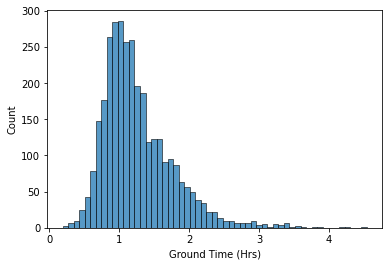

In [469]:
sns.histplot(data=groundtime_hfocc,x='Ground Time (Hrs)')
plt.show()

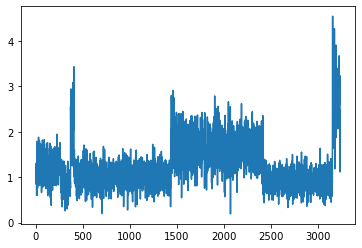

In [470]:
plt.plot(groundtime_hfocc['Ground Time (Hrs)'].values)
plt.show()

In [471]:
turning_points_test(groundtime_hfocc['Ground Time (Hrs)'].values)

2148

In [472]:
Mean_R = ((2*len(groundtime_hfocc))-4) / 3

In [473]:
Sigma_R2 = ((16*len(groundtime_hfocc))-29) / 90

In [474]:
test_stat = (16-Mean_R) / math.sqrt(Sigma_R2)

In [475]:
if test_stat < stats.norm.ppf(0.025) or test_stat > stats.norm.ppf(0.975):
    print("Reject the null hypothesis that the data is independent")
else:
    print("Fail to reject the null hypothesis that the data is independent")

Reject the null hypothesis that the data is independent


#### The table below gives us the mean, standard deviation, minimum, and max of the ground times for each of the nine types of planes that landed at Port-au-Prince Airport. 

In [476]:
groundtime_hfocc.groupby(['A/C Size','Affiliation']).agg({'Ground Time (Hrs)': ['mean','std','min','max']})

Ground Time (Hrs)                              
                                  mean       std       min       max
A/C Size Affiliation                                                
N        GOV                  1.222711  0.279529  0.380333  1.945333
         MIL                  1.030109  0.237086  0.197333  1.720333
         NGO                  1.634915  0.357279  0.190333  2.786333
S        GOV                  0.893000  0.238572  0.258333  1.389333
         MIL                  0.962262  0.223028  0.350333  1.378333
         NGO                  0.926988  0.212434  0.331333  1.634333
W        GOV                  2.333171  0.519290  1.247333  3.429333
         MIL                  1.918970  0.449577  1.082333  2.907333
         NGO                  2.775972  0.637275  1.113333  4.540333

### Splitting GroundTime HFOCC DF into 9 DF's based on A/C Size & Affiliation

In [477]:
grouped = groundtime_hfocc.groupby(by = ['A/C Size', 'Affiliation'])

In [478]:
dfs = [grouped.get_group(x) for x in grouped.groups]

In [479]:
dfs

[    Request Status Arrival Date A/C Size Affiliation  Ground Time (Hrs)
 0         Complete   2010-01-16        N         GOV           1.287333
 1         Complete   2010-01-16        N         GOV           1.142333
 2         Complete   2010-01-16        N         GOV           1.035333
 3         Complete   2010-01-16        N         GOV           0.883333
 4         Complete   2010-01-16        N         GOV           1.006333
 ..             ...          ...      ...         ...                ...
 260       Complete   2010-02-28        N         GOV           1.126333
 261       Complete   2010-02-28        N         GOV           1.094333
 262       Complete   2010-02-28        N         GOV           1.126333
 263       Complete   2010-02-28        N         GOV           1.034333
 264       Complete   2010-03-01        N         GOV           1.264333
 
 [265 rows x 5 columns],
      Request Status Arrival Date A/C Size Affiliation  Ground Time (Hrs)
 407        Complete   

### Fitting Ground Time Distributions for 9 plane types

#### Narrow Government Planes

,sumsquare_error,aic,bic,kl_div
lognorm,15.836134,204.706372,-729.881225,inf
gamma,15.837284,204.716917,-729.861990,inf
norm,16.025876,199.260672,-732.304714,inf


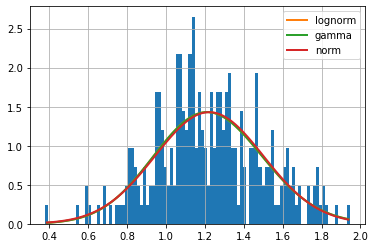

In [552]:
f = Fitter(dfs[0]['Ground Time (Hrs)'], distributions=['lognorm','gamma','norm'])
f.fit()
f.summary()

In [553]:
f.fitted_param['norm']

(1.2227106918238992, 0.2790015639649879)

#### Narrow Military Planes

,sumsquare_error,aic,bic,kl_div
norm,4.046200,253.069307,-5223.723067,inf
lognorm,4.051169,256.423604,-5215.682275,inf
gamma,4.064656,258.244107,-5212.498398,inf


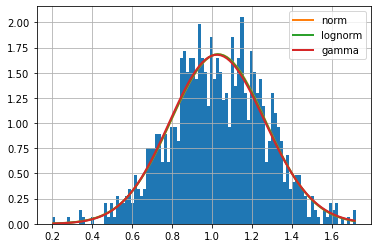

In [554]:
f = Fitter(dfs[1]['Ground Time (Hrs)'], distributions=['lognorm','gamma','norm'])
f.fit()
f.summary()

In [555]:
f.fitted_param['norm']

(1.0301089074460683, 0.23696206356796995)

#### Narrow Non-Government Planes

,sumsquare_error,aic,bic,kl_div
gamma,1.357170,444.931314,-6187.844367,inf
lognorm,1.357777,445.237412,-6187.420119,inf
norm,1.362518,439.065879,-6190.970405,inf


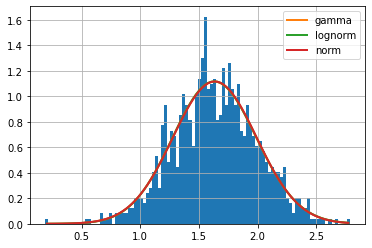

In [556]:
f = Fitter(dfs[2]['Ground Time (Hrs)'], distributions=['lognorm','gamma','norm'])
f.fit()
f.summary()

In [557]:
f.fitted_param['norm']

(1.6349145569620251, 0.3570900776715849)

#### Small Government Planes

,sumsquare_error,aic,bic,kl_div
lognorm,70.686603,100.379793,-27.587068,inf
norm,70.714722,97.767695,-32.199269,inf
gamma,70.725372,100.614830,-27.529497,inf


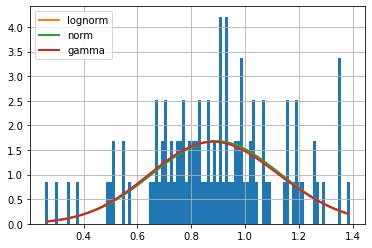

In [558]:
f = Fitter(dfs[3]['Ground Time (Hrs)'], distributions=['lognorm','gamma','norm'])
f.fit()
f.summary()

In [559]:
f.fitted_param['norm']

(0.893, 0.23743344597979715)

#### Small Military Planes

,sumsquare_error,aic,bic,kl_div
gamma,177.857751,90.058283,78.019704,inf
lognorm,178.000979,88.329777,78.076052,inf
norm,178.001868,85.410020,73.827907,inf


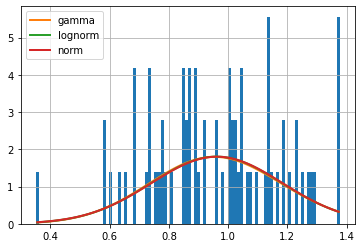

In [560]:
f = Fitter(dfs[4]['Ground Time (Hrs)'], distributions=['lognorm','gamma','norm'])
f.fit()
f.summary()

In [561]:
f.fitted_param['norm']

(0.9622619047619045, 0.22142953225597986)

#### Small Non-Government Planes

,sumsquare_error,aic,bic,kl_div
norm,6.907527,198.657900,-3434.235245,inf
gamma,6.919443,199.969633,-3426.359320,inf
lognorm,6.942367,198.800329,-3423.918338,inf


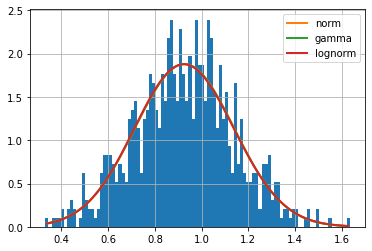

In [562]:
f = Fitter(dfs[5]['Ground Time (Hrs)'], distributions=['lognorm','gamma','norm'])
f.fit()
f.summary()

In [563]:
f.fitted_param['norm']

(0.9269878048780488, 0.21228977769967547)

#### Wide Government Planes

,sumsquare_error,aic,bic,kl_div
norm,53.730311,205.203673,21.025033,inf
lognorm,53.741566,207.357999,24.643700,inf
gamma,54.051932,206.022285,24.856767,inf


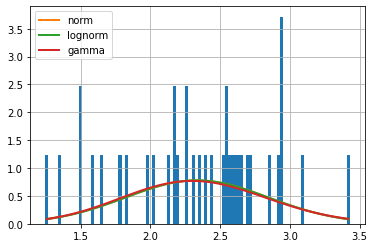

In [564]:
f = Fitter(dfs[6]['Ground Time (Hrs)'], distributions=['lognorm','gamma','norm'])
f.fit()
f.summary()

In [565]:
f.fitted_param['norm']

(2.3331711711711716, 0.5122246399886884)

#### Wide Military Planes

,sumsquare_error,aic,bic,kl_div
gamma,123.217149,170.881887,53.965065,inf
norm,123.219988,169.355373,50.469318,inf
lognorm,123.286535,171.789566,53.983643,inf


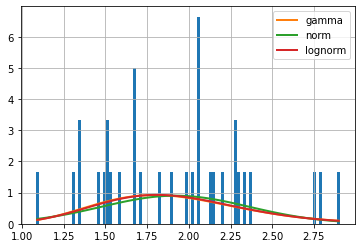

In [566]:
f = Fitter(dfs[7]['Ground Time (Hrs)'], distributions=['lognorm','gamma','norm'])
f.fit()
f.summary()

In [567]:
f.fitted_param['norm']

(1.918969696969697, 0.4427123574116254)

#### Wide Non-Government Planes

,sumsquare_error,aic,bic,kl_div
gamma,8.714609,342.603917,-173.812184,inf
lognorm,8.714838,342.621983,-173.810001,inf
norm,8.723703,341.010684,-178.144454,inf


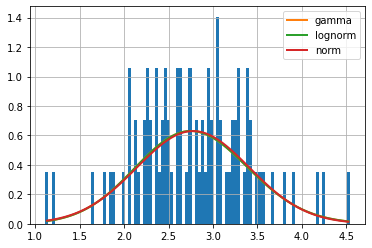

In [568]:
f = Fitter(dfs[8]['Ground Time (Hrs)'], distributions=['lognorm','gamma','norm'])
f.fit()
f.summary()

In [569]:
f.fitted_param['norm']

(2.775971887550201, 0.63342451511202)

### The previous 9 distributions show that the normal distribution fits the data for ground times just as good or better than the lognormal and gamma distribution. The normal distribution has a chance of allowing for a negative ground time value, however since the standard deviations are about 3 times smaller than the means, there is an extremely small chance of this happening. The mean and standard deviation of each of the 9 distributions is listed under each graph and are also located in the table above as well. 